In [1]:
from data_utils import load_data, notnan_indices, downsample_signal
from constants import Constants as C

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [2]:
data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data[C.T]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data[C.A]
pmo_b = data[C.B]
temp = data[C.TEMP]
data.sample(15, random_state=2)

,TIME,PMO6V-A,PMO6V-B,TEMPERATURE
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


In [3]:
data_nn = data[[C.T, C.A, C.B]].dropna()
t_nn = data_nn[C.T]
x_a_nn = data_nn[C.A]
x_b_nn = data_nn[C.B]
ratio_a_b = x_a_nn/x_b_nn

#plt.figure(5, figsize=(16, 8))
#plt.plot(t_nn, ratio_a_b, t_nn, np.exp(a*t_nn+b))
#plt.plot(t_nn, np.log(ratio_a_b-0.995), t_nn, a*t_nn+b)
#plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
#plt.show()

In [61]:
data = np.stack((t_nn, ratio_a_b)).T
data = data[::1]
data.shape

(21524, 2)

In [62]:
y= data[:,1]
X = data[:,0].T.reshape(-1,1)

In [73]:
X_for_gp = np.stack((np.zeros((10, 1)), X), axis=2)

ValueError: all input arrays must have the same shape

In [71]:
np.zeros((10, 1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

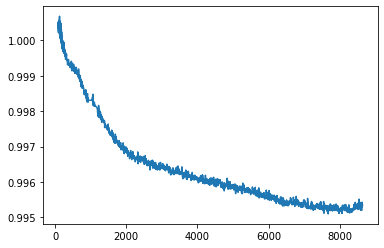

In [35]:
plt.plot(X, y)

# SVR attempt

In [9]:
from sklearn.svm import SVR

cost_param = [10**i for i in range(-2,0)]
epsilon_param = [10**i for i in range(-2, 0)]

param_grid = [
    {
        'C' : cost_param,
        'epsilon' : epsilon_param,
    },
]


grid = GridSearchCV(SVR(kernel='rbf', 
                        gamma='scale'),
                    cv=10, 
                    n_jobs=-1, 
                    param_grid=param_grid)

In [11]:
start_time = time.time()
grid.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.1146769523620605 seconds ---


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
clf = SVR(C=1e-3, gamma='auto', epsilon=1e-20, kernel='rbf')
clf.fit(X, y)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=1e-20, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
clf.get_params()

{'C': 0.001,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1e-20,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

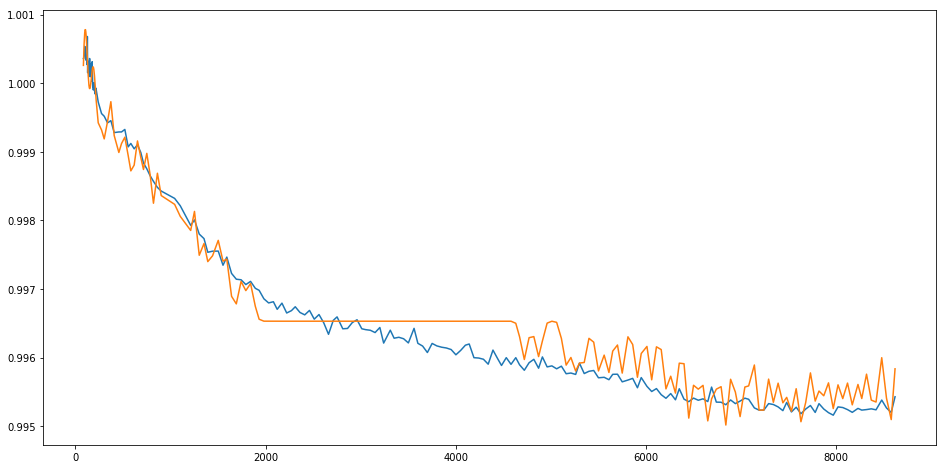

In [154]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, X, grid.predict(X.reshape(-1,1)))

# Gaussian processes

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared

In [12]:
kernel = 10*(WhiteKernel() * RBF() + RationalQuadratic() + ExpSineSquared())

In [13]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

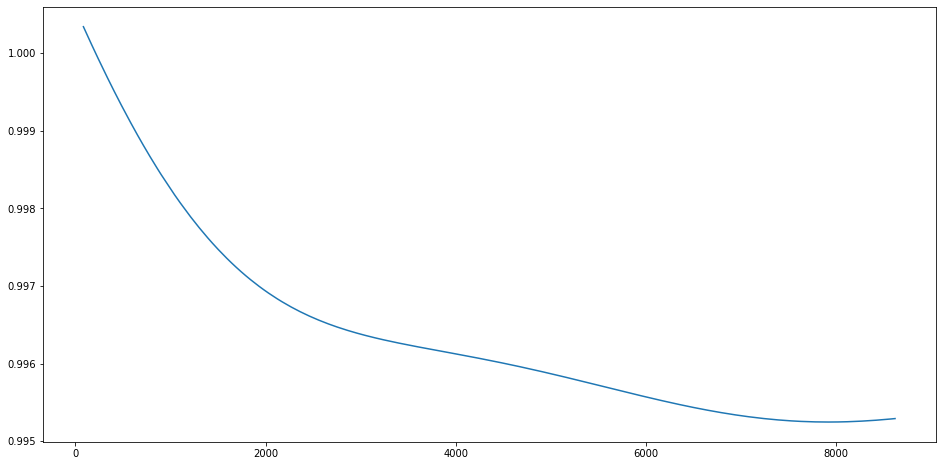

In [15]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, gpr.predict(X))

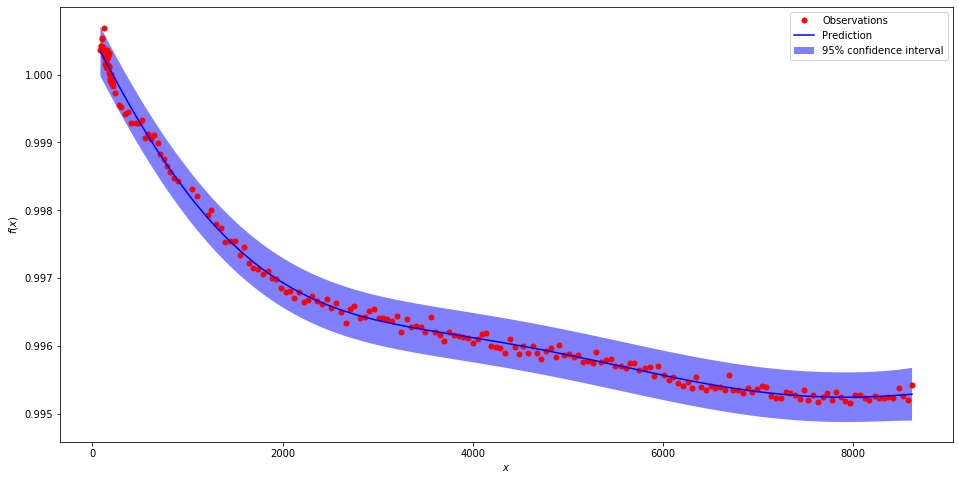

In [16]:
y_pred, sigma = gpr.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(0.995, 1)
#plt.xlim(2000, 4000)
plt.legend(loc='upper right')

# Decreasing, Convex Splines through point (0,1)

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import minimize
import warnings

In [75]:
class DegradationSpline():
    def __init__(self, k=3, s_params=(-14,0), steps=30):
        self.k = k
        self.s_params = self._s_param_generator(*s_params)
        self.steps = steps

    def _s_param_generator(self, start, finish):
        for i in range(start, finish):
            for j in range(1, 10):
                yield j * 10 ** i

    def _guess(self, x, y, k, s, w=None):
        """Do an ordinary spline fit to provide knots"""
        return splrep(x, y, w, k=k, s=s)

    def _err(self, c, x, y, t, k, w=None):
        """The error function to minimize"""
        diff = y - splev(x, (t, c, k))
        if w is None:
            diff = np.einsum('...i,...i', diff, diff)
        else:
            diff = np.dot(diff * diff, w)
        return np.abs(diff)

    def _spline_dirichlet(self, x, y, k=3, s=0, w=None):
        t, c0, k = self._guess(x, y, k, s, w=w)
        x0 = x[0]  # point at which 1 is required
        xl = x[-1]
        con = {'type': 'eq',
               'fun': lambda c: splev(x0, (t, c, k), der=0) - 1,
               }
        opt = minimize(self._err, c0, (x, y, t, k, w), constraints=con)
        copt = opt.x
        return UnivariateSpline._from_tck((t, copt, k))

    def _is_decreasing(self, spline, x):
        spline_derivative = spline.derivative()
        return np.all(spline_derivative(x.ravel()) < 0)

    def _is_convex(self, spline, x):
        spline_derivative_2 = spline.derivative().derivative()
        return np.all(spline_derivative_2(x.ravel()) > 0)

    def _find_convex_decreasing_spline(self, x, y):
        for s in self.s_params:
            spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
            if self._is_decreasing(spline, x) and self._is_convex(spline, x):
                return spline
        raise Exception(
            'Could not find increasng and convex spline for this set of sensitivity parameters and fitting data x, y')

    def _find_convex_decreasing_spline_binary_seach(self, x, y):
        """
        for start it should be weird
        for end it should be decreasing
        """
        start = 0
        end = 1
        mid = (end - start) / 2
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
        step = 1
        while step <= self.steps:
            if self._is_decreasing(spline, x):
                end = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            else:
                start = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            step += 1
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=end)
        if not self._is_convex(spline, x):
            warnings.warn("Spline is decrasing but not convex.")
        return spline
    
    def test(self, x, y, s):
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
        print(self._is_decreasing(spline, x))
        print(self._is_convex(spline, x))
        return spline(x)
                
    def fit(self, x, y):
        self.sp = self._find_convex_decreasing_spline_binary_seach(x, y)

    def predict(self, x):
        return self.sp(x)

    
class SplineWithInitialOne: 
    def __init__(self, k=3, s=1e-3):
        self.k = k
        self.s = s
        
    def fit(self, x, y):
        self.sp = spline_dirichlet(x.ravel(), y, self.k, self.s)
        return self.sp
    
    def predict(self, x):
        return self.sp(x)
    
    def get_params(self, deep=True):
        return {'k' : self.k,
                's' : self.s}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class ThinningFolds:
    
    def __init__(self, t=0.1):
        self.t = t
    
    def split(self, x, *params):
        l = len(x)
        n = int(1/self.t)
        for i in range(n):
            train = np.arange(i, l, n)
            test = np.array([j for j in range(l) if j % n != i])
            yield (train, test)
    
    def get_n_splits(self, x, *params):
        n = int(1/self.t)
        return n

In [63]:
model = DegradationSpline(s_params=(-15,0))

In [64]:
model.fit(X, y)

1 0.5
is decreasing
2 0.25
is decreasing
3 0.125
is decreasing
4 0.0625
is decreasing
5 0.03125
is decreasing
6 0.015625
is decreasing
7 0.0078125
is decreasing
8 0.00390625
is decreasing
9 0.001953125
is decreasing
10 0.0009765625
is decreasing
11 0.00048828125
is decreasing
12 0.000244140625
is decreasing
13 0.0001220703125
is weird
14 6.103515625e-05
is weird
15 9.1552734375e-05
is weird
16 7.62939453125e-05
is weird
17 8.392333984375e-05
is weird
18 8.0108642578125e-05
is weird
19 8.20159912109375e-05
is weird
20 8.106231689453125e-05
is weird
21 8.153915405273438e-05
is weird
22 8.130073547363281e-05
is weird
23 8.14199447631836e-05
is weird
24 8.13603401184082e-05
is weird
25 8.13901424407959e-05
is weird
26 8.137524127960205e-05
is weird
27 8.138269186019897e-05
is weird
28 8.137896656990051e-05
is weird
29 8.138082921504974e-05
is weird
30 8.137989789247513e-05
is weird
31 8.138036355376244e-05
is weird
32 8.138013072311878e-05
is weird
33 8.138024713844061e-05
is weird
34 8.13

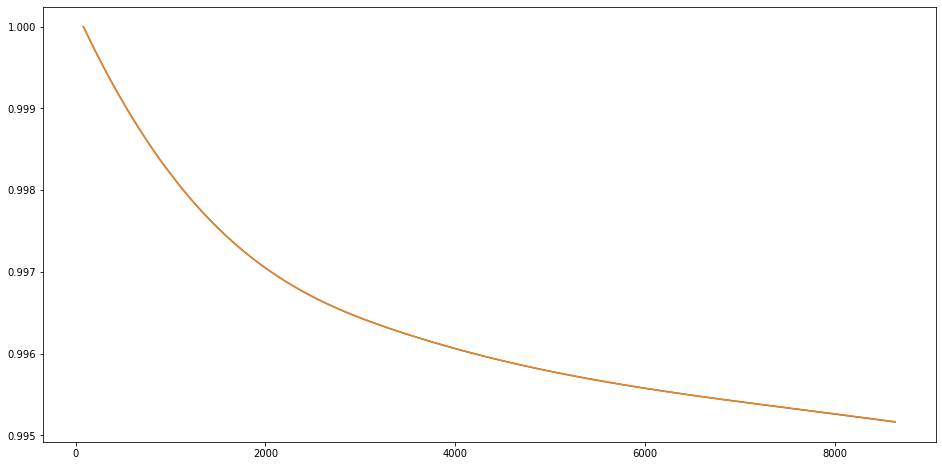

In [78]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), model.predict(X.ravel()), X.ravel(), model1.predict(X.ravel()))

In [76]:
model1 = DegradationSpline(s_params=(-15,0))

In [77]:
model1.fit(X[::5], y[::5])

1 0.5
is decreasing
2 0.25
is decreasing
3 0.125
is decreasing
4 0.0625
is decreasing
5 0.03125
is decreasing
6 0.015625
is decreasing
7 0.0078125
is decreasing
8 0.00390625
is decreasing
9 0.001953125
is decreasing
10 0.0009765625
is decreasing
11 0.00048828125
is decreasing
12 0.000244140625
is decreasing
13 0.0001220703125
is decreasing
14 6.103515625e-05
is decreasing
15 3.0517578125e-05
is weird
16 1.52587890625e-05
is weird
17 2.288818359375e-05
is weird
18 1.9073486328125e-05
is weird
19 2.09808349609375e-05
is weird
20 2.002716064453125e-05
is weird
21 2.0503997802734375e-05
is weird
22 2.0265579223632812e-05
is weird
23 2.0384788513183594e-05
is weird
24 2.0325183868408203e-05
is weird
25 2.03549861907959e-05
is weird
26 2.034008502960205e-05
is weird
27 2.0347535610198975e-05
is weird
28 2.0343810319900513e-05
is weird
29 2.0345672965049744e-05
is weird
30 2.0344741642475128e-05
is weird


In [37]:
model.test(X, y, 1e-1)

True
False


array([[1.        ],
       [0.99999237],
       [0.99998451],
       [0.9999772 ],
       [0.99997024],
       [0.99996163],
       [0.999953  ],
       [0.9999454 ],
       [0.99993815],
       [0.99992338],
       [0.99991695],
       [0.99991126],
       [0.99990506],
       [0.99989844],
       [0.99989238],
       [0.99988245],
       [0.99987597],
       [0.99986688],
       [0.99986142],
       [0.999855  ],
       [0.99984871],
       [0.9998425 ],
       [0.99983623],
       [0.99982984],
       [0.99982371],
       [0.99981739],
       [0.99981115],
       [0.99980512],
       [0.99979942],
       [0.99979343],
       [0.99978715],
       [0.99978017],
       [0.99977451],
       [0.9997685 ],
       [0.99976219],
       [0.99975524],
       [0.99974924],
       [0.999743  ],
       [0.99973691],
       [0.99973076],
       [0.99972517],
       [0.99971894],
       [0.99967429],
       [0.9996034 ],
       [0.99954758],
       [0.99947838],
       [0.99941017],
       [0.999

True
False


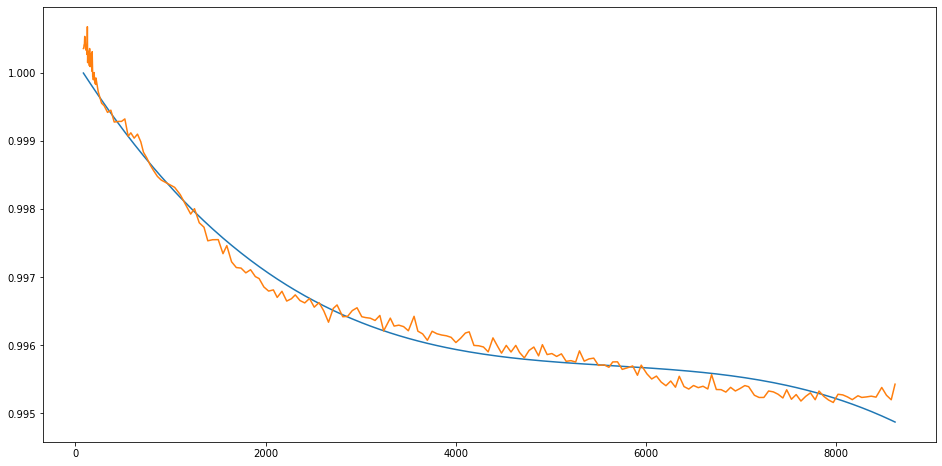

In [48]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), model.test(X, y, 1e-1), X.ravel(), y)

In [23]:
cost_param = [10**i for i in range(-2,0)]
epsilon_param = [10**i for i in range(-2, 0)]

param_grid = [{
            'C' : cost_param,
            'epsilon' : epsilon_param,
              },]

grid = GridSearchCV(SplineWithInitialOne(k=3),
                    cv=ThinningFolds(t=0.02),
                    n_jobs=-1,
                    scoring= make_scorer(mean_squared_error),
                    param_grid=param_grid)

In [ ]:
start_time = time.time()
grid.fit(X.ravel(), y)
print("--- %s seconds ---" % (time.time() - start_time))